This notebook illustrates a binary classification task by means of logistic regression using PyTorch.

We will use the IRIS dataset, which provides width and height of iris flowers petals and sepals, as well as their species (Iris setosa, Iris virginica and Iris versicolor).

You can find more information about the IRIS dataset in:
- https://en.wikipedia.org/wiki/Iris_flower_data_set
- https://archive.ics.uci.edu/ml/datasets/iris


We will try to predict whether the flower belongs to the IRIS setosa species based on its sepal length and width.


In [1]:
!pip install matplotlib --quiet
!pip install scikit-learn --quiet
!pip install torch --quiet

In [2]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random

In [3]:
seed = 30
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

Let's load the data:
- X is the two first data fields (sepal length and width).
- Y is 1 if the flower is Iris Setosa and 0 otherwise.

In [4]:
iris = datasets.load_iris()
linearly_separable_label = 0
x_vals = iris.data[:, :2]
y_vals = (np.array(iris.target) == linearly_separable_label).astype(np.float32)
print("x = {}...".format(x_vals[:10, :]))
print("\ny = {}".format(y_vals))

x = [[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]
 [5.4 3.9]
 [4.6 3.4]
 [5.  3.4]
 [4.4 2.9]
 [4.9 3.1]]...

y = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


Let's visualize the X data. Notice that the data is **linearly separable**, so a simple logistic regression should be able to address the problem.

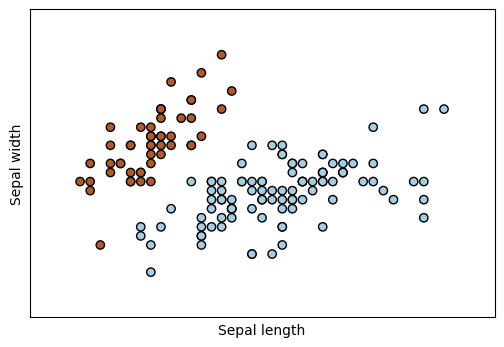

In [5]:
plt.figure(1, figsize=(6, 4))
plt.scatter(x_vals[:, 0], x_vals[:, 1], c=y_vals, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
h_min, h_max = x_vals[:, 0].min() - .5, x_vals[:, 0].max() + .5
v_min, v_max = x_vals[:, 1].min() - .5, x_vals[:, 1].max() + .5
plt.xlim(h_min, h_max)
plt.ylim(v_min, v_max)
plt.xticks(())
plt.yticks(())
plt.show()

We will define the models as a linear layer followed by a sigmoid function, which gives us a value between 0 and 1, which we will assimilate to probability of belonging to the positive class.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logreg_model = nn.Sequential(nn.Linear(2, 1), nn.Sigmoid()).to(device)

Given that this is a binary classification problem, as loss function we will use the **Binary Cross Entropy**.

In [7]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(logreg_model.parameters(), lr=0.01)

Now we perform the normal training iterations.

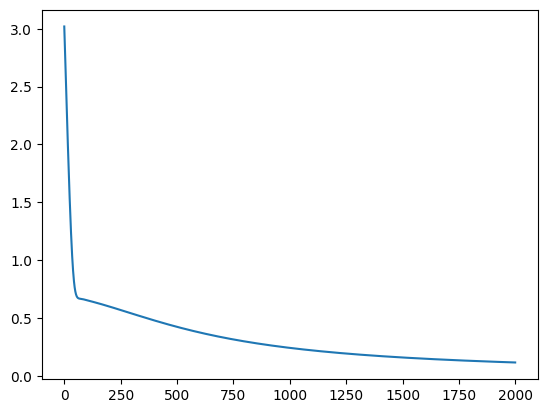

In [8]:
losses = []
num_epochs = 2000
inputs = torch.Tensor(x_vals).to(device)
expected_outputs = torch.Tensor(y_vals).unsqueeze(1).to(device)
for epoch in range(1, num_epochs + 1):
  optimizer.zero_grad()
  model_outputs = logreg_model(inputs)
  loss = criterion(model_outputs, expected_outputs)
  loss.backward()
  optimizer.step()
  losses.append(loss.item())

plt.plot(losses)
plt.show()

Now let's visualize the decision boundary.

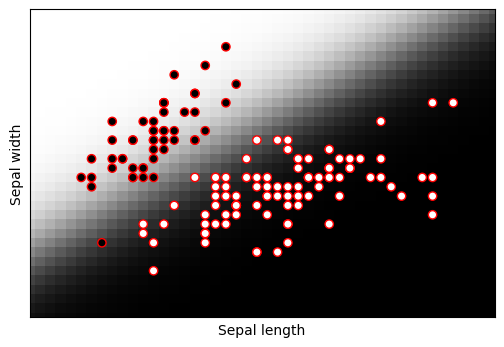

In [9]:
plt.figure(1, figsize=(6, 4))
mesh_step = 0.1
xx, yy = np.meshgrid(np.arange(h_min, h_max, mesh_step), np.arange(v_min, v_max, mesh_step))
input = torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
z = logreg_model(input).detach().cpu().numpy()
z = z.reshape(xx.shape)
plt.pcolormesh(xx, yy, z, cmap=plt.cm.gray)
plt.scatter(x_vals[:, 0], x_vals[:, 1], c=y_vals, edgecolors='r', cmap=plt.cm.gray_r)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.show()

Now we will use a multilayer perceptron (MLP) instead of a single linear layer:

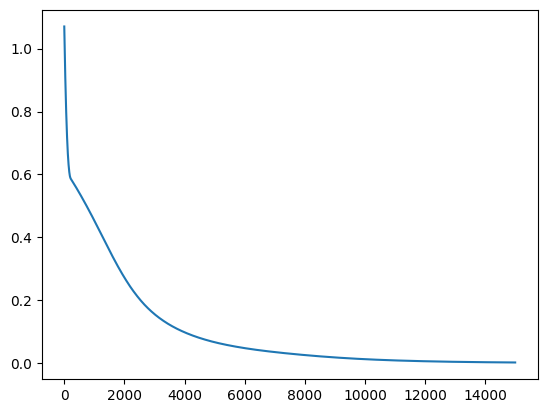

In [10]:
mlp_model = nn.Sequential(nn.Linear(2, 1), nn.ReLU(), nn.Linear(1, 1), nn.Sigmoid()).to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
mlp_model.apply(init_weights)

mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
losses = []
num_epochs = 15000
for epoch in range(1, num_epochs + 1):
  inputs = torch.Tensor(x_vals).to(device)
  expected_outputs = torch.Tensor(y_vals).unsqueeze(1).to(device)
  mlp_optimizer.zero_grad()
  model_outputs = mlp_model(inputs)
  loss = criterion(model_outputs, expected_outputs)
  loss.backward()
  mlp_optimizer.step()
  losses.append(loss.item())

plt.plot(losses)
plt.show()

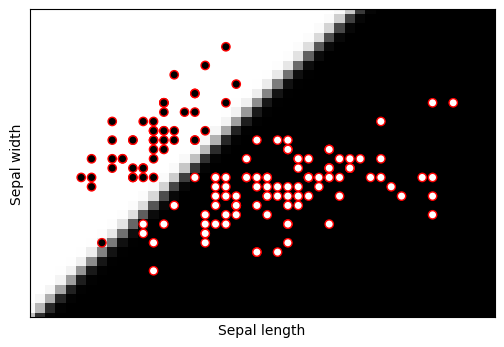

In [11]:
plt.figure(1, figsize=(6, 4))
mesh_step = 0.1
xx, yy = np.meshgrid(np.arange(h_min, h_max, mesh_step), np.arange(v_min, v_max, mesh_step))
input = torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
z = mlp_model(input).detach().cpu().numpy()
z = z.reshape(xx.shape)
plt.pcolormesh(xx, yy, z, cmap=plt.cm.gray)
plt.scatter(x_vals[:, 0], x_vals[:, 1], c=y_vals, edgecolors='r', cmap=plt.cm.gray_r)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.show()